In [1]:
## Import common python libraries
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Import from root_numpy library
import root_numpy
from root_numpy import root2array, rec2array

# Import panda library
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix
from pandas.core.index import Index
import pandas.core.common as com

# Import scipy
import scipy
from scipy.stats import ks_2samp
import scipy as sp

# Import itertools
import itertools
from itertools import cycle

# Import Jupyter
from IPython.core.interactiveshell import InteractiveShell

# Import scikit-learn
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RandomizedLasso

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import RFECV
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, 
                             auc, average_precision_score, precision_score, 
                             brier_score_loss, recall_score, f1_score, log_loss, 
                             classification_report, precision_recall_curve, accuracy_score)

from sklearn.dummy import DummyClassifier

from sklearn.externals import joblib
from sklearn import feature_selection

# Import imblearn
import imblearn
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Optimize 
from skopt import gp_minimize
from skopt.plots import plot_convergence

# python utilities
from collections import defaultdict, Counter

# python regular-expression
import re

# Sciki-kit learn graph 
from sklearn.tree import export_graphviz

# Check the versions of libraries/packages
print("Python version " + sys.version)
print("Sklearn version " + sklearn.__version__)
print("Root_numpy version " + root_numpy.__version__)
print("Numpy version " + np.__version__)
print("Scipy version " + scipy.__version__)
print("Pandas version " + pd.__version__)
print("Matplotlib version " + matplotlib.__version__)
print("Seaborn version " + sns.__version__)
print("Imblance version " +imblearn.__version__)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Specifying which nodes should be run interactively
InteractiveShell.ast_node_interactivity = "all"
print(__doc__)

Welcome to ROOTaaS 6.06/08


/Users/DesyFellow/Library/Python/2.7/lib/python/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.12.0. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


Python version 2.7.13 (v2.7.13:a06454b1afa1, Dec 17 2016, 12:39:47) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
Sklearn version 0.18.1
Root_numpy version 4.7.2
Numpy version 1.12.1
Scipy version 0.18.1
Pandas version 0.19.0+515.gd0a281f
Matplotlib version 2.0.0
Seaborn version 0.8.dev
Imblance version 0.2.1
Automatically created module for IPython interactive environment


## Load data files

In [2]:
## Data loading function

def load(sig_filename, bkg_filename, category, features):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    sig_filename : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    bkg_filename : array, shape = [n_samples, n_classes]
    category: string
    features: array, shape = [n_features]

    Returns
    -------
    data : pandas.DataFrame
    """

    signal = root2array(sig_filename, category, features)
    signal = rec2array(signal)

    backgr = root2array(bkg_filename, category, features)
    backgr = rec2array(backgr)

    # for sklearn data is usually organised
    # into one 2D array of shape (n_samples x n_features)
    # containing all the data and one array of categories
    # of length n_samples
    X = np.concatenate((signal, backgr))
    y = np.concatenate((np.ones(signal.shape[0]), np.zeros(backgr.shape[0])))

    # convert to numpy ndarray into pandas dataframe
    dataframe_X = pd.DataFrame(data=X, columns=features)
    dataframe_y = pd.DataFrame(data=y, columns=['y'])

    data = pd.concat([dataframe_X, dataframe_y], axis=1)

    return data

In [3]:
## Load input data files

# Feature names
branch_names = """mass_tag_tag_min_deltaR,median_mass_jet_jet,
    maxDeltaEta_tag_tag,mass_higgsLikeDijet,HT_tags,
    btagDiscriminatorAverage_tagged,mass_jet_tag_min_deltaR,
    mass_jet_jet_min_deltaR,mass_tag_tag_max_mass,maxDeltaEta_jet_jet,
    centrality_jets_leps,centrality_tags,globalTimesEventWeight""".split(",")

features = [c.strip() for c in branch_names]
features = (b.replace(" ", "_") for b in features)
features = list(b.replace("-", "_") for b in features)

wall = time.time()
process = time.clock()

# Load dataset
signal_sample = "combined/signalMC.root"
background_sample = "combined/backgroundMC.root"
tree_category = "event_mvaVariables_step7_cate4"

data = load(signal_sample, background_sample, tree_category, features)

print "Total number of events: {}\nNumber of features: {}".format(data.shape[0], data.shape[1])

# Store a copy for later use
df_archived = data.copy(deep=True)

print "\nWall time to read in file input: ", time.time()-wall
print "CPU time to read in file input: ", time.clock()-process

Total number of events: 11502
Number of features: 14

Wall time to read in file input:  0.19686794281
CPU time to read in file input:  0.183924


In [4]:
## Function to extract class label counts and percentage

def class_info(classes):
    # Store the number of signal and background events
    class_count = {}
    counts = Counter(classes)
    total = sum(counts.values())

    for cls in counts.keys():
        class_count[class_label[cls]] = counts[cls]
        print("%10s: %7d  =  % 5.1f%%" % (class_label[cls], counts[cls], float(counts[cls])/float((total))*100.0))

    return (class_count["signal"], class_count["background"])

In [5]:
## Determine class label counts and percentages

class_label = {0.0: "background", 1.0: "signal"}
class_info(data.y);

background:    6777  =   58.9%
    signal:    4725  =   41.1%


In [6]:
## Create features dataframe and target array

df_X = data.drop("y", axis=1, inplace=False)
df_y = data["y"]

In [7]:
# Plot AUC for ROC curve for several classifiers out-of-the-box

# Set feature scaling type
scaler = RobustScaler()

# prepare models: create a mapping of ML classifier name to algorithm
pipe_classifiers = {
    'SVC':  make_pipeline(scaler, SVC(class_weight="balanced")), # sample_weight included
    'LogisticRegression'    : make_pipeline(scaler, LogisticRegression(class_weight="balanced")),
    'AdaBoostClassifier'    : make_pipeline(None,   AdaBoostClassifier()),
    'RandomForestClassifier': make_pipeline(None,   RandomForestClassifier(min_samples_leaf=10)),
    'DecisionTreeClassifier': make_pipeline(None,   DecisionTreeClassifier(min_samples_leaf=10,
                                                                           class_weight="balanced")),
    'GradientBoostingClassifier': make_pipeline(None,   GradientBoostingClassifier(min_samples_leaf=10)),
    'BaggingClassifier': make_pipeline(None,   BaggingClassifier(n_estimators=1000)),
    'ExtraTreesClassifier' :  make_pipeline(None, ExtraTreesClassifier(min_samples_leaf=10)),#,
    #'LinearDiscriminantAnalysis':  make_pipeline(scaler, LinearDiscriminantAnalysis()),
    #'KNeighborsClassifier':  make_pipeline(scaler, KNeighborsClassifier()),
    #'GaussianNB' :  make_pipeline(scaler, GaussianNB()), 
    #'MLPClassifier':  make_pipeline(scaler, MLPClassifier()), 
}

## Early stopping plots

In [ ]:
## Validation curve definition

def early_stopping_curve(clf, X, y):
    """Early stopping curve.

    Parameters
    ----------
    clf : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    X : array, shape = [n_samples, n_classes]
    y : array, shape = [n_samples, n_classes]
    Returns
    -------
    plt : matplotlib
    """
    
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev, y_eval = train_test_split(X, y, test_size=.33,
                                                   random_state=seed)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed+31415)
    
    sample_weight_train = X_train["globalTimesEventWeight"].values
    
    sample_weight_test = X_test["globalTimesEventWeight"].values

    
    
    X_train = X_train.drop('globalTimesEventWeight', axis=1, inplace=False)
    X_test = X_test.drop('globalTimesEventWeight', axis=1, inplace=False)
    
    clf.fit(X_train, y_train, **{'sample_weight': sample_weight_train}) 

    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')
    
    test_score = np.empty(len(clf.estimators_))
    train_score = np.empty(len(clf.estimators_))

    for i, pred in enumerate(clf.staged_predict_proba(X_test)):
        test_score[i] = 1-roc_auc_score(y_test, pred[:,1], sample_weight=sample_weight_test)

    for i, pred in enumerate(clf.staged_predict_proba(X_train)):
        train_score[i] = 1-roc_auc_score(y_train, pred[:,1], sample_weight=sample_weight_train)

    best_iter = np.argmin(test_score)
    learn = clf.get_params()['learning_rate']
    depth = clf.get_params()['max_depth']
        
    test_line = plt.plot(test_score, label='test (1-roc_auc=%.3f)'%(test_score[best_iter]))

    colour = test_line[-1].get_color()
    plt.plot(train_score, '--', color=colour, 
             label='train (1-roc_auc=%.3f)\nlearn=%.1f depth=%i'
             %(train_score[best_iter],learn,depth))

    plt.title("Early stopping curve")
    plt.xlabel("Number of boosting iterations")
    plt.ylabel("1 - area under ROC")
    plt.legend(loc='best')
    plt.axvline(x=best_iter, color=colour)
    
    return plt.show()

In [ ]:
##  plot the early stopping curve for the fitted classifier
# and check with the test set at which number of n_estimators we reach the minimum test error.

wall = time.time()
process = time.clock()

# Set of hyper-parameter selected
opts = dict(max_depth=3, 
            learning_rate=0.01, 
            n_estimators=1200)

clf = GradientBoostingClassifier(**opts)

early_stopping_curve(clf, df_X, df_y)

print "\nWall time to generate early stopping plots: ", time.time()-wall
print "CPU time to generate early stopping plots: ", time.clock()-process

## Feature ranking and Selection

In [ ]:
## Feature ranking 

def feature_ranking_plot(X, importances, std, indices, title):

    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')
    
    X_tmp = X.drop('globalTimesEventWeight', axis=1, inplace=False)

    print(title)
    for i in xrange(X_tmp.shape[1]):
        print("%d. %s (%f)" % (i + 1, X_tmp.columns[indices[i]], importances[indices[i]]))

    # Plot the feature importances of the model
    plt.title(title)
    plt.bar(range(X_tmp.shape[1]), importances[indices],
            color="r", yerr=std, align="center") 
    plt.xticks(range(X_tmp.shape[1]), X_tmp.columns[indices], rotation='vertical')
    plt.xlim([-1, X_tmp.shape[1]])
    plt.tight_layout()

    return plt.show()

In [ ]:
## Extract feature selection

def extract_feature_selected(clf, X, y):
    
    # Split data into a development and evaluation set
    X_dev,X_eval, y_dev, y_eval = train_test_split(df_X, df_y, test_size=.33, 
                                                   random_state=seed)
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                        random_state=seed+31415)

    sample_weight = X_train["globalTimesEventWeight"].values
    
    X_train = X_train.drop('globalTimesEventWeight', axis=1, inplace=False)
    X_test = X_test.drop('globalTimesEventWeight', axis=1, inplace=False)
    
    clf.fit(X_train,y_train, **{clf.steps[1][0].lower()+'__sample_weight': sample_weight}) 
    
    select_indices = clf.named_steps['SELECT'].transform(
    np.arange(len(X_train.columns)).reshape(1, -1))

    feature_names = X_train.columns[select_indices]
    
    return feature_names

In [ ]:
## Feature selection

def features_selection_model_performance(clf, X, y, parameter_set):

    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')
    
    this_scores = list()
    score_means = list()
    score_stds = list()

    params = {'SELECT__k': 'top k features', 
              'SELECT__threshold': 'feature threshold',
              'SELECT__n_features_to_select': 'n features to select',
              'SELECT__percentile': 'percentile',
              'SELECT__cv': 'k-fold',
              'SELECT__selection_threshold':'selection threshold'}

    label = [keyname for keyname in clf.get_params().keys() if keyname in params.keys()][0]
    
    sample_weights = X["globalTimesEventWeight"].values
    
    for k in parameter_set:

        param = {label: k}
        clf.set_params(**param) 
        
        # Compute cross-validation score using 1 CPU
        this_scores = cross_val_score(clf, 
                                      X.drop('globalTimesEventWeight', axis=1, inplace=False), y,
                                      cv=3, n_jobs=1, 
                                      fit_params={'classifier__sample_weight': sample_weights})
        score_means.append(this_scores.mean())
        score_stds.append(this_scores.std())

    plt.errorbar(parameter_set, score_means, np.array(score_stds))

    model = clf.steps[1][0]

    title = 'Performance of the {}-{} varying for features selected'.format(model,
                                                                            clf.get_params().keys()[1])
    
    plt.title(title)
    plt.xlabel(params[label])
    plt.ylabel('Prediction rate')

    print  extract_feature_selected(clf, X, y).values[0]
    
    return plt.show()

In [ ]:
## Univariate Statistics: variance threshold

process = time.time()
process = time.clock()

# Sample weights
sample_weights = df_X["globalTimesEventWeight"].values

# Removing features with low variance
select = VarianceThreshold(threshold=0.0)

# Configure pipeline 
pipe = Pipeline([('SELECT', select), ('classifier', RandomForestClassifier())])

# Features selected by variance threshold
_=pipe.fit(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y,
         **{'classifier__sample_weight': sample_weights})

# Extract feature importances, standard deviations, and indices
importances = pipe.named_steps["SELECT"].variances_
std = np.std([importance for importance in importances], axis=0)*np.ones(len(importances))
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, importances, std, indices, "Feature importances based on variance ranking")

# Variance thresholds
threshold = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

# Plot feature selection
features_selection_model_performance(pipe, df_X, df_y, threshold)

print "Wall time to produce feature ranking plots: ", time.time()-wall
print "CPU time to prodduce feature ranking plots: ", time.clock()-process

In [ ]:
## Univariate Statistics: percentile (of the highest feature scores)

process = time.time()
process = time.clock()

# Sample weights
sample_weights = df_X["globalTimesEventWeight"].values

# Univariate feature selection according to a percentile of the highest scores
select = feature_selection.SelectPercentile(f_classif)

# Configure pipeline
pipe = Pipeline([('SELECT', select), ('classifier', RandomForestClassifier())])

# Features selected based on k-highest scores
_=pipe.fit(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y,
         **{'classifier__sample_weight': sample_weights})

# Extract feature importances, standard deviations, and indices
importances = pipe.named_steps["SELECT"].scores_
std = np.std([score for score in importances], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, importances, std, indices, "Feature importances based percentile of the highest feature scores classification ranking")

# Percentile selections
percentiles = [6, 10, 15, 20, 30, 40, 60, 80, 100]

# Plot feature selection
features_selection_model_performance(pipe, df_X, df_y, percentiles)

print "Wall time to produce feature ranking plots: ", time.time()-wall
print "CPU time to prodduce feature ranking plots: ", time.clock()-process

In [ ]:
### Univariate Statistics: K-best features

process = time.time()
process = time.clock()

# Sample weights
sample_weights = df_X["globalTimesEventWeight"].values

#  Univariate feature selection based on the k highest scores
select = SelectKBest(score_func=f_classif, k=6)

# Configure pipeline 
pipe = Pipeline([('SELECT', select), ('classifier', RandomForestClassifier())])

# Features selected based on k-highest scores
_=pipe.fit(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y,
         **{'classifier__sample_weight': sample_weights})

# Extract feature importances, standard devations, and indices
importances = pipe.named_steps["SELECT"].scores_
std = np.std([importance for importance in importances], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, importances, std, indices, "Feature importances based k-best features classification ranking")

# K-best features
k = [2, 4, 6, 8, 10, 12]

# Plot feature selection
features_selection_model_performance(pipe, df_X, df_y, k)


print "Wall time to produce feature ranking plots: ", time.time()-wall
print "CPU time to prodduce feature ranking plots: ", time.clock()-process

In [ ]:
## Model-Based Feature Selection: SelectFromModel (RandomForrestClassifier)

# The SelectFromModel class selects all features that have an importance measure 
# of the feature (as provided by the supervised model) greater than the provided 
# threshold. 

process = time.time()
process = time.clock()

# Sample weights
sample_weights = df_X["globalTimesEventWeight"].values

# Selection using SelectFromModel based on RandomForestClassifier  
select = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=seed), threshold="median")

# Configure pipeline
pipe = Pipeline([('SELECT', select), ('classifier', RandomForestClassifier())])

# Features selected by SelectFromModel using the RandomForestClassifier
_=pipe.fit(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y,
         **{'classifier__sample_weight': sample_weights})

# Extract feature importances, standard deviations, and indices
importances = pipe.named_steps["SELECT"].estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe.named_steps["SELECT"].estimator_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, importances, std, indices, "RandomForestClassifier model-based feature importances ranking")

# Select n features
#p = ["mean", "median"]
p = [0.0001, 0.0005, 0.001, 0.01, 0.1]

# Plot feature selection
features_selection_model_performance(pipe, df_X, df_y, p)


print "Wall time to produce feature ranking plots: ", time.time()-wall
print "CPU time to prodduce feature ranking plots: ", time.clock()-process

In [ ]:
## Model-Based Feature Selection: SelectFromModel (ExtraTreesClassifier)

process = time.time()
process = time.clock()

# Sample weights
sample_weights = df_X["globalTimesEventWeight"].values

# Selection using select from model based on extra trees classifier
select = SelectFromModel(ExtraTreesClassifier(random_state=seed), threshold="median")

# Configure pipeline
pipe = Pipeline([('SELECT', select), ('classifier', RandomForestClassifier())])

# Features selected by SelectFromModel using the ExtraTreesClassifier
_=pipe.fit(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y,
         **{'classifier__sample_weight': sample_weights})

# Extract feature importances, standard deviations, and indices
importances = pipe.named_steps["SELECT"].estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe.named_steps["SELECT"].estimator_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, importances, std, indices, "ExtraTree Model-based feature importances ranking")

# Selection based on threshold
threshold = [0.001, 0.01, 0.017, 0.019] 

# Plot feature selection
features_selection_model_performance(pipe, df_X, df_y, threshold)


print "\nWall time to generate features selection performance plots: ", time.time()-wall
print "CPU time to generate features selection performance plots: ", time.clock()-process

In [ ]:
## Iterative Feature Selection: Recursive feature elimination (without cross-validation)

process = time.time()
process = time.clock()

# Sample weights
sample_weights = df_X["globalTimesEventWeight"].values

# Recursive feature elimination 
select = RFE(estimator=RandomForestClassifier(), step=1)

# Configure pipeline
pipe = Pipeline([('SELECT', select), ('classifier', RandomForestClassifier())])

# Features selected based on RFE ranking
_=pipe.fit(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y,
         **{'classifier__sample_weight': sample_weights})

# Extract feature ranking, standard deviations, and indices
importances = pipe.named_steps["SELECT"].ranking_
std = np.std([importance for importance in importances], axis=0)
indices = np.argsort(importances)[::-1]
             
# n features to select
n_features_to_select = [2, 3, 5, 7]

# Plot feature ranking
feature_ranking_plot(df_X, importances, std, indices, "RFE model-based feature importances ranking")

# Plot feature selection
features_selection_model_performance(pipe, df_X, df_y, n_features_to_select)

print "Wall time to produce feature ranking plots: ", time.time()-wall
print "CPU time to prodduce feature ranking plots: ", time.clock()-process

In [ ]:
## Iterative Feature Selection: Recursive feature elimination with cross-validation

process = time.time()
process = time.clock()

# Sample weights
sample_weights = df_X["globalTimesEventWeight"].values

# Recursive feature elimination (RFE) with cross-validation 
select = RFECV(estimator=RandomForestClassifier(), step=1, 
               cv=StratifiedKFold(3), scoring='accuracy')

# Configure pipeline
pipe = Pipeline([('SELECT', select), ('classifier', RandomForestClassifier())])

# Features selected based on k-highest scores
_=pipe.fit(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y,
         **{'classifier__sample_weight': sample_weights})

# Extract feature importances, standard deviations, and indices
importances = pipe.named_steps["SELECT"].ranking_
std = np.std([importance for importance in importances], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature ranking
feature_ranking_plot(df_X, importances, std, indices, "RFECV model-based feature importances ranking")

# Extract feature selection
pipe.fit(df_X, df_y)

kfold = [3, 5]

# Plot feature selection
features_selection_model_performance(pipe, df_X, df_y, kfold)

print("Optimal number of features : %d" % pipe.named_steps["SELECT"].n_features_)

# Plot number of features VS. cross-validation scores
_=plt.figure()
_=plt.xlabel("Number of features selected")
_=plt.ylabel("Cross validation score (nb of correct classifications)")
_=plt.plot(range(1, len(pipe.named_steps["SELECT"].grid_scores_) + 1), pipe.named_steps["SELECT"].grid_scores_)
plt.show()


print "Wall time to produce feature ranking plots: ", time.time()-wall
print "CPU time to prodduce feature ranking plots: ", time.clock()-process

## Model building: feature scaling, selection, hyper-parameter optimization, and final model evaluation

In [ ]:
## Standard nested k-fold cross-validation

def nestedGridSearchCV(Classifier, X, y, outer_cv, inner_cv, 
                       parameter_grid, scoring="accuracy"):
    """Nested k-fold crossvalidation."""
    
    """ 
    Parameters
    ----------
    Classifier : array, shape = [n_samples]
            true class, intergers in [0, n_classes - 1)
    X : array, shape = [n_samples, n_classes]
    y : array, shape = [n_samples, n_classes]
    outer_cv:  shape = [n_samples, n_classes]
    inner_cv:  shape = [n_samples, n_classes]
    parameter_grid: shape = [n_samples, n_classes]
    scoring:   shape = [n_samples, n_classes]
    
    Returns
    -------
    Grid classifier: classifier re-fitted to full dataset
    """    
    
    
    outer_scores = []
    
    for training_samples, test_samples in outer_cv.split(X, y):

        # Training datasets
        x_training_temp = pd.DataFrame(X.iloc[training_samples], columns=features)

        x_training = x_training_temp.drop('globalTimesEventWeight', axis=1, inplace=False)
        y_training = pd.Series(y.iloc[training_samples])

        # Extract sample weight
        weights_training = x_training_temp["globalTimesEventWeight"].values

        # Testing datasets
        x_testing_temp = pd.DataFrame(X.iloc[test_samples], columns=features)

        x_testing = x_testing_temp.drop('globalTimesEventWeight', axis=1, inplace=False)
        y_testing = pd.Series(y.iloc[test_samples])

        # set up grid search configuration
        cv = GridSearchCV(estimator=Classifier, param_grid=parameter_grid,
                          cv=inner_cv, scoring="accuracy", 
                          n_jobs=-1,
                          fit_params={"classifier__sample_weight": weights_training})
                         
        # train on the training set
        cv.fit(x_training, y_training)
        
        # evaluate
        outer_scores.append(cv.score(x_testing, y_testing))

    # Print final model evaluation (i.e. mean cross-validation scores)
    print "Final model evaluation (mean cross-val scores):\n", np.array(outer_scores).mean()
    
    # note: the scoring is being done without the weights associated with X
    # fit model to entire training dataset (i.e tuning & validation dataset)
    cv.best_estimator_.fit(X.drop('globalTimesEventWeight', axis=1, inplace=False), y,
                           **{"classifier__sample_weight": X["globalTimesEventWeight"].values})
    
    
    return cv

In [ ]:
## Setup common configuration: cross-validation type, feature scaling, and model pipeline 

# Standard K-Fold cross-validation
k_fold=5
outer_kfold_cv = KFold(n_splits=k_fold, shuffle=True, random_state=seed)
inner_kfold_cv = KFold(n_splits=k_fold-1, shuffle=True, random_state=seed)

# preprocessing using 0-1 scaling by removing the mean and scaling to unit variance 
scaler = RobustScaler()

# Default pipeline setup with dummy place holder steps
pipe = Pipeline([('feature_scaling', None), 
                 ('feature_selection', None), 
                 ('classifier', DummyClassifier())]
               )

# Split data into a development and evaluation set
X_dev,X_eval, y_dev,y_eval = train_test_split(df_X, df_y,
                                              test_size=0.33, random_state=seed)
# Split development set into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                    random_state=seed)

In [ ]:
# feature selection
select = VarianceThreshold()

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'feature_selection': [select],
     'feature_selection__threshold': [0.4],
     'feature_scaling': [scaler]
    }
]

grid = nestedGridSearchCV(Classifier=pipe,
                          X=X_train, y=y_train, 
                          outer_cv=outer_kfold_cv, inner_cv=inner_kfold_cv, 
                          parameter_grid=param_grid, 
                          scoring="roc_auc")

y_pred = grid.predict(X_test.drop('globalTimesEventWeight', axis=1, inplace=False))
report = classification_report( y_test, y_pred )
print report

In [ ]:
# Evaluate best selected model

print("Pipeline steps:\n{}".format(grid.best_estimator_.steps))

# extract the first step 
components = grid.best_estimator_.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = grid.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_)) 
print("Test set score: {:.2f}".format(grid.best_estimator_.score(df_X.drop('globalTimesEventWeight', 
                                                                           axis=1, inplace=False), df_y))) 
print("Best parameters: {}".format(grid.best_params_))

In [ ]:
# feature selection
select = SelectKBest(k=8)

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'feature_selection': [select],
     'feature_selection__k': [10],
     'feature_scaling': [scaler]
    }
]

grid = nestedGridSearchCV(Classifier=pipe,
                          X=X_train, y=y_train, 
                          outer_cv=outer_kfold_cv, inner_cv=inner_kfold_cv, 
                          parameter_grid=param_grid, 
                          scoring="roc_auc")


y_pred = grid.predict(X_test.drop('globalTimesEventWeight', axis=1, inplace=False))
report = classification_report( y_test, y_pred )
print report

In [ ]:
# Evaluate best selected model

print("Pipeline steps:\n{}".format(grid.best_estimator_.steps))

# extract the first step 
components = grid.best_estimator_.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = grid.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_)) 
print("Test set score: {:.2f}".format(grid.best_estimator_.score(df_X.drop('globalTimesEventWeight', 
                                                                           axis=1, inplace=False), df_y))) 
print("Best parameters: {}".format(grid.best_params_))

In [ ]:
# feature selection
select = feature_selection.SelectPercentile(f_classif)

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'feature_selection': [select],
     'feature_selection__percentile': [90],
     'feature_scaling': [scaler]
    }
]

grid = nestedGridSearchCV(Classifier=pipe,
                          X=X_train, y=y_train, 
                          outer_cv=outer_kfold_cv, inner_cv=inner_kfold_cv, 
                          parameter_grid=param_grid, 
                          scoring="roc_auc")

y_pred = grid.predict(X_test.drop('globalTimesEventWeight', axis=1, inplace=False))
report = classification_report( y_test, y_pred )
print report

In [ ]:
# Evaluate best selected model

print("Pipeline steps:\n{}".format(grid.best_estimator_.steps))

# extract the first step 
components = grid.best_estimator_.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = grid.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_)) 
print("Test set score: {:.2f}".format(grid.best_estimator_.score(df_X.drop('globalTimesEventWeight', 
                                                                           axis=1, inplace=False), df_y))) 
print("Best parameters: {}".format(grid.best_params_))

In [ ]:
# feature selection
select = RFE(estimator=RandomForestClassifier(), n_features_to_select=8, step=1)

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'feature_selection': [select],
     'feature_selection__n_features_to_select': [10],
     'feature_scaling': [scaler]
    }
]

grid = nestedGridSearchCV(Classifier=pipe,
                          X=X_train, y=y_train, 
                          outer_cv=outer_kfold_cv, inner_cv=inner_kfold_cv, 
                          parameter_grid=param_grid, 
                          scoring="roc_auc")

y_pred = grid.predict(X_test.drop('globalTimesEventWeight', axis=1, inplace=False))
report = classification_report( y_test, y_pred )
print report

In [ ]:
# Evaluate best selected model

print("Pipeline steps:\n{}".format(grid.best_estimator_.steps))

# extract the first step 
components = grid.best_estimator_.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = grid.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_)) 
print("Test set score: {:.2f}".format(grid.best_estimator_.score(df_X.drop('globalTimesEventWeight',
                                                                           axis=1, inplace=False), df_y))) 
print("Best parameters: {}".format(grid.best_params_))

In [ ]:
# feature selection
select = RFECV(estimator=RandomForestClassifier(), step=1,  
               cv=StratifiedKFold(3), scoring='accuracy')

# create classifier for use in scikit-learn
model = GradientBoostingClassifier()

# prepare models: create a mapping of ML classifier name to algorithm
param_grid = [
    {'classifier': [model],
     'classifier__n_estimators': [100],
     'classifier__learning_rate': [0.1],
     'feature_selection': [select],
     'feature_selection__cv': [7],
     'feature_scaling': [scaler]
    }
]

grid = nestedGridSearchCV(Classifier=pipe,
                          X=X_train, y=y_train, 
                          outer_cv=outer_kfold_cv, inner_cv=inner_kfold_cv, 
                          parameter_grid=param_grid, 
                          scoring="roc_auc")

y_pred = grid.predict(X_test.drop('globalTimesEventWeight', axis=1, inplace=False))
report = classification_report( y_test, y_pred )
print report

In [ ]:
# Evaluate best selected model

print("Pipeline steps:\n{}".format(grid.best_estimator_.steps))

# extract the first step 
components = grid.best_estimator_.named_steps["feature_scaling"]
print("components: {}".format(components))
classifier = grid.best_estimator_.named_steps["classifier"]
print("GradientBoostingClassifier classifier step:\n{}".format(classifier))
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_)) 
print("Test set score: {:.2f}".format(grid.best_estimator_.score(df_X.drop('globalTimesEventWeight', 
                                                                           axis=1, inplace=False), df_y))) 
print("Best parameters: {}".format(grid.best_params_))

## Implementing a Weighted Majority Rule Ensemble Classifier

In order to trained a set of equally well performing models and balance out their individual weaknesses.

In [ ]:
## Esemble classifier

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()

estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)]
voting='hard' #'soft'

eclf = VotingClassifier(estimators=estimators, voting=voting, weights=[1,1,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression',
                                                 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_val_score(clf, df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y, 
                             cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))



## Handling unblanaced dataset

In [ ]:
# Apply the random over-sampling
ros = RandomOverSampler()
X_overresampled, y_overresampled = ros.fit_sample(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y)

# Apply the random under-sampling
rus = RandomUnderSampler()
X_underresampled, y_underresampled = rus.fit_sample(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y)

# Apply SMOTE SVM
sm = SMOTE(kind='svm')
X_resampled, y_resampled = sm.fit_sample(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y)

In [ ]:
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression',
                                                 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_val_score(clf, X_overresampled, y_overresampled, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [ ]:
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression',
                                                 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_val_score(clf, X_underresampled, y_underresampled, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [ ]:
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression',
                                                 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_val_score(clf, X_resampled, y_resampled, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

## Hyper-parameter tuning:  Bayesian optimization using Gaussian Processes

In [ ]:
# define objective loss function to minimize/maximize

def objective(params):    
    # Split development set into a train and test set
    X_train, X_test, y_train, y_test= train_test_split(df_X.drop('globalTimesEventWeight', axis=1, inplace=False), df_y, test_size=0.33, random_state=42)

    X = X_train
    y = y_train
    
    max_depth, learning_rate, max_features, min_samples_split, min_samples_leaf = params

    clf.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   max_features=max_features,
                   min_samples_split=min_samples_split, 
                   min_samples_leaf=min_samples_leaf)

    #return -np.mean(cross_val_score(clf, X, y, cv=5, n_jobs=-1,
    #                                scoring="neg_mean_absolute_error"))

    #return np.mean(cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring="roc_auc"))
    shuffle = KFold(n_splits=5, shuffle=True)
    score = cross_val_score(clf, X_train, y_train, cv=shuffle, scoring='roc_auc', n_jobs=-1)

    #return 1-score.mean()

    return score.mean()

In [ ]:
n_features = df_X.drop('globalTimesEventWeight', axis=1, inplace=False).shape[1]

parameters  = [(1, 4),                           # max_depth
               (10**-2, 10**0, "log-uniform"),   # learning_rate  (sample from "log-uniform" distribution)
               (9, n_features),                  # max_features
               (2, 100),                         # min_samples_split
               (1, 100)]                         # min_samples_leaf

In [ ]:
# Optimize hyper-parameters of classifier

process = time.time()
process = time.clock()

clf = GradientBoostingClassifier(n_estimators=50, random_state=0)

clf_gp = gp_minimize(objective, parameters, n_calls=30, random_state=0)

"Best score=%.4f" % clf_gp.fun

print "\nWall time to generate classifier models: ", time.time()-wall
print "CPU time to generate classifier models: ", time.clock()-process

In [ ]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (clf_gp.x[0], clf_gp.x[1], 
                            clf_gp.x[2], clf_gp.x[3], 
                            clf_gp.x[4]))

In [ ]:
plot_convergence(clf_gp);
plt.show()

In [12]:
# Split data into a development and evaluation set
X_dev,X_eval, y_dev,y_eval = train_test_split(df_X, df_y,
                                              test_size=0.33, random_state=seed)
# Split development set into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                    random_state=seed)

## HyperOpt

In [13]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,20)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    #'scale': hp.choice('scale', [0, 1]),
    #'normalize': hp.choice('normalize', [0, 1])
}

In [14]:
from sklearn.naive_bayes import BernoulliNB

def hyperopt_train_test(params):
    clf = RandomForestClassifier(**params)
    
    return cross_val_score(clf, X_train.drop('globalTimesEventWeight', axis=1, inplace=False), y_train).mean()


In [15]:
best = 0

def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
    print 'new best:', best, params
    return {'loss': -acc, 'status': STATUS_OK}

In [16]:
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)

print 'best:'
print best

new best: 0.660861754781 {'max_features': 4, 'n_estimators': 11, 'criterion': 'entropy', 'max_depth': 11}
new best: 0.660861754781 {'max_features': 4, 'n_estimators': 6, 'criterion': 'entropy', 'max_depth': 2}
new best: 0.660861754781 {'max_features': 3, 'n_estimators': 1, 'criterion': 'entropy', 'max_depth': 14}
new best: 0.673448299035 {'max_features': 4, 'n_estimators': 19, 'criterion': 'gini', 'max_depth': 8}
new best: 0.673448299035 {'max_features': 3, 'n_estimators': 13, 'criterion': 'entropy', 'max_depth': 6}
new best: 0.673448299035 {'max_features': 3, 'n_estimators': 11, 'criterion': 'entropy', 'max_depth': 1}
new best: 0.673448299035 {'max_features': 1, 'n_estimators': 9, 'criterion': 'entropy', 'max_depth': 9}
new best: 0.673448299035 {'max_features': 1, 'n_estimators': 2, 'criterion': 'entropy', 'max_depth': 9}
new best: 0.673448299035 {'max_features': 4, 'n_estimators': 8, 'criterion': 'gini', 'max_depth': 5}
new best: 0.673448299035 {'max_features': 2, 'n_estimators': 15,

0 n_estimators


1 max_depth


2 max_features


3 criterion


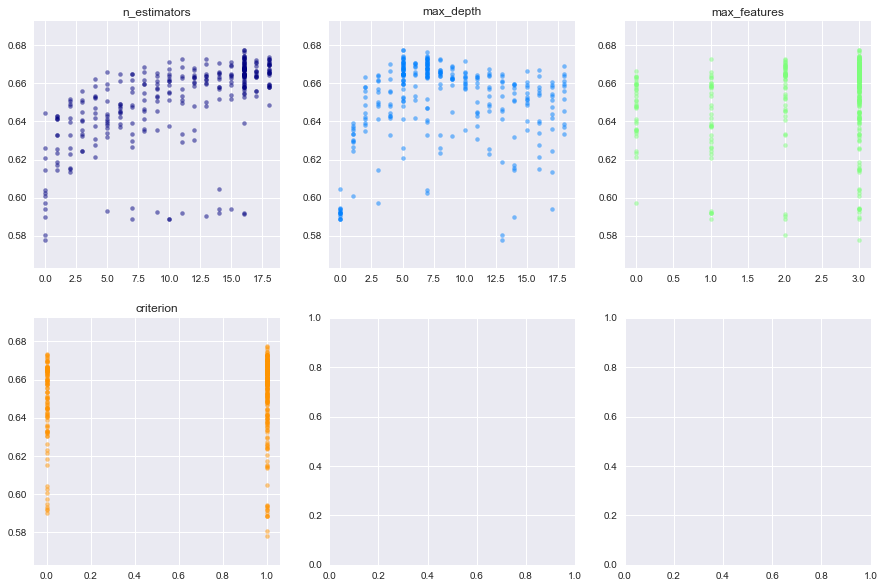

In [24]:

parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion']
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

cmap = plt.cm.jet

for i, val in enumerate(parameters):
    print i, val
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    #xs, ys = zip(sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i/3,i%3].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i/3,i%3].set_title(val)

plt.show()

## Systematic steps to hyper-parameter tuning

In [ ]:
# Split data into a development and evaluation set
X_dev,X_eval, y_dev,y_eval = train_test_split(df_X, df_y,
                                              test_size=0.33, random_state=seed)
# Split development set into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.33,
                                                    random_state=seed)

In [ ]:
# Handle model fit and feature importance

def modelfit(alg, y, X, performCV=True, printFeatureImportance=True, cv_folds=5):
    
    # Customize the major grid
    fig, ax = plt.subplots()
    ax.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    ax.set_facecolor('white')

    #Extract sample weights from datasest
    sample_weights = X["globalTimesEventWeight"].values
    
    #Fit the algorithm on the data
    alg.fit(X.drop('globalTimesEventWeight', axis=1, inplace=False), y)
        
    #Predict training set:
    predictions = alg.predict(X.drop('globalTimesEventWeight', axis=1, inplace=False))
    predprob = alg.predict_proba(X.drop('globalTimesEventWeight', axis=1, inplace=False))[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, 
                                   X.drop('globalTimesEventWeight', axis=1, inplace=False), 
                                   y, cv=cv_folds, scoring='roc_auc',
                                   fit_params={'sample_weight': sample_weights})
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % accuracy_score(y, predictions, sample_weight=sample_weights)
    print "AUC Score (Train): %f" % roc_auc_score(y, predprob, sample_weight=sample_weights)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),
                                                                                 np.std(cv_score),
                                                                                 np.min(cv_score),
                                                                                 np.max(cv_score))

    # Extract features set
    features_set = X.drop('globalTimesEventWeight', axis=1, inplace=False).columns.values
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, features_set).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    return plt.show()

In [ ]:
## Out-of-the-box model

gbm0 = GradientBoostingClassifier(random_state=10)

modelfit(gbm0, y_train, X_train)

In [ ]:
## Fix learning rate and number of estimators for tuning tree-based parameters

param_test1 = {'n_estimators':range(20, 200, 10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=200,
                                                               min_samples_leaf=50, max_depth=8, 
                                                               max_features='sqrt', subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
gsearch1.fit(X_train.drop('globalTimesEventWeight', axis=1, inplace=False), y_train)

In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
## Tuning tree-specific parameters

param_test2 = {'max_depth':range(2, 10, 2), 'min_samples_split':range(100, 201, 20)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30, max_features='sqrt',
                                                               min_samples_leaf=50, subsample=0.8, random_state=10), 
                        param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train.drop('globalTimesEventWeight', axis=1, inplace=False), y_train)

In [ ]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
# Take the max_depth of 7 as optimum and not try different values for higher min_samples_split. 
# It might not be the best idea always but here if you observe the output closely, 
# max_depth of 7 works better in most of the cases. 
# Also, we can test for 5 values of min_samples_leaf, from 30 to 70 in steps of 10, 
# along with higher min_samples_split.

param_test3 = {'min_samples_split':range(100, 201, 20), 'min_samples_leaf':range(25,201,25)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30,
                                                               max_depth=6,max_features='sqrt', subsample=0.8, 
                                                               random_state=10), 
                        param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train.drop('globalTimesEventWeight', axis=1, inplace=False), y_train)

In [ ]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
# Here we get the optimum values as 100 for min_samples_split and 25 for min_samples_leaf. 
# Also, we can see the CV score increasing to 0.73264671016122429 now.
# Let's fit the model again on this and have a look at the feature importance.

modelfit(gsearch3.best_estimator_,  y_train, X_train)

In [ ]:
param_test4 = {'max_features':range(2, 12, 1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30,max_depth=6, 
                                                               min_samples_split=100, min_samples_leaf=25, 
                                                               subsample=0.8, random_state=10),
                        param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train.drop('globalTimesEventWeight', axis=1, inplace=False), y_train)

In [ ]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

## Tuning subsample and making models with lower learning rate

In [ ]:
## The next step would be try different subsample values. Lets take values 0.6,0.7,0.75,0.8,0.85,0.9.

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=30, max_depth=6,
                                                               min_samples_split=100, min_samples_leaf=25, 
                                                               subsample=0.8, random_state=10, max_features=3),
param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train.drop('globalTimesEventWeight', axis=1, inplace=False), y_train)

In [ ]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
## Lets decrease the learning rate to half, i.e. 0.05 with twice (30) the number of trees. 

gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=60,
                                         max_depth=6, min_samples_split=100,
                                         min_samples_leaf=25, subsample=0.8, 
                                         random_state=10, max_features=3)
modelfit(gbm_tuned_1, y_train, X_train)

In [ ]:
## Now lets reduce to one-tenth of the original value, i.e. 0.01 for 30 trees.

gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=30,
                                         max_depth=6, min_samples_split=100,
                                         min_samples_leaf=25, subsample=0.80, 
                                         random_state=10, max_features=3)

modelfit(gbm_tuned_2,  y_train, X_train)

In [ ]:
## Lets decrease to one-twentieth of the original value, i.e. 0.005 for 1200 trees.

gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=60,
                                         max_depth=6, min_samples_split=100, 
                                         min_samples_leaf=25, subsample=0.80, 
                                         random_state=10, max_features=3,
                                         warm_start=True)

modelfit(gbm_tuned_3, y_train, X_train, performCV=False)

In [ ]:
## Here we see that the score reduced very slightly. So lets run for 1500 trees.

gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=100,
                                         max_depth=6, min_samples_split=100, 
                                         min_samples_leaf=25, subsample=0.80, 
                                         random_state=10, max_features=3,
                                         warm_start=True)
modelfit(gbm_tuned_4,  y_train, X_train, performCV=False)